# ProQuest Newspaper Data Analysis

This notebook analyzes the ProQuest newspaper dataset to understand:
- Data coverage and completeness
- Temporal distribution of articles
- Newspaper sources and their time spans

## Setup

In [ ]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import utils
import numpy as np
from datasets import Dataset
import os

# Set plotting style to make fonts larger and generally more readable
sns.set_context(context='talk', font_scale=1.5)

/home/mourad/.conda/envs/econ-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

Load different ProQuest data files and combine them into a single DataFrame.

In [3]:
# Define data paths
DATA_DIR = "/data/mourad/narratives/proquest/raw_from_TDM/"

# Function to load data with consistent parameters
def load_proquest_data(filename, scope):
    df = pd.read_csv(f"{DATA_DIR}{filename}", compression="gzip", sep="\t")
    df['scope'] = scope
    return df

# Load all datasets
data_files = {
    'local1': ('local-data.csv.gz', 'local'),
    'local2': ('local-data-2.csv.gz', 'local'),
    'national1': ('local-data-3-national.csv.gz', 'national'),
    'old': ('processed-data-1923-1960.csv.gz', 'unknown'),
    'recent': ('processed-data-2010-2025.csv.gz', 'recent')
}

dataframes = {name: load_proquest_data(filename, scope) 
              for name, (filename, scope) in data_files.items()}

# Combine all dataframes
df = pd.concat(dataframes.values(), axis=0)

# Basic data cleaning
total_rows = len(df)
df = df[df.text.notna()]
empty_texts = total_rows - len(df)

# Split year_month into separate columns
df[['year', 'month']] = df['year_month'].str.split('-', expand=True)
df.year = df.year.astype(int)
df.month = df.month.astype(int)

print(f"Total rows: {total_rows:,}")
print(f"Rows with empty text: {empty_texts:,} ({empty_texts/total_rows:.1%})")
print(f"Final dataset size: {len(df):,}")

Total rows: 5,135,069
Rows with empty text: 210,972 (4.1%)
Final dataset size: 4,924,097


## Newspaper Source Analysis

Analyze the distribution and coverage of different newspaper sources.

In [5]:
# Get unique newspaper titles and their time spans
newspaper_stats = df[['title', 'year']].copy()

# Calculate start and end years for each newspaper
newspaper_stats['start_year'] = newspaper_stats.groupby('title')['year'].transform('min')
newspaper_stats['end_year'] = newspaper_stats.groupby('title')['year'].transform('max')
newspaper_stats['article_count'] = newspaper_stats.groupby('title')['title'].transform('count')

# Remove duplicates to get one row per newspaper
newspaper_stats = newspaper_stats.drop('year', axis=1).drop_duplicates().sort_values('title')

# Display summary statistics
print(f"Total unique newspapers: {len(newspaper_stats):,}")
print("\nTime span statistics:")
print(newspaper_stats[['start_year', 'end_year']].describe())

# Save the newspaper statistics
output_path = "output/stats/proquest_newspaper_names.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
newspaper_stats.to_csv(output_path, index=False)
print(f"\nSaved newspaper statistics to: {output_path}")

Total unique newspapers: 868

Time span statistics:
        start_year     end_year
count   868.000000   868.000000
mean   1996.071429  2011.906682
std      20.217490    17.095277
min    1923.000000  1924.000000
25%    1991.000000  2008.000000
50%    1999.000000  2017.000000
75%    2008.000000  2024.000000
max    2024.000000  2025.000000

Saved newspaper statistics to: output/stats/proquest_newspaper_names.csv


## Visualization - Newspaper Sources & Article Distribution 

Create visualizations to better understand the distribution of articles over time and the coverage of newspapers.

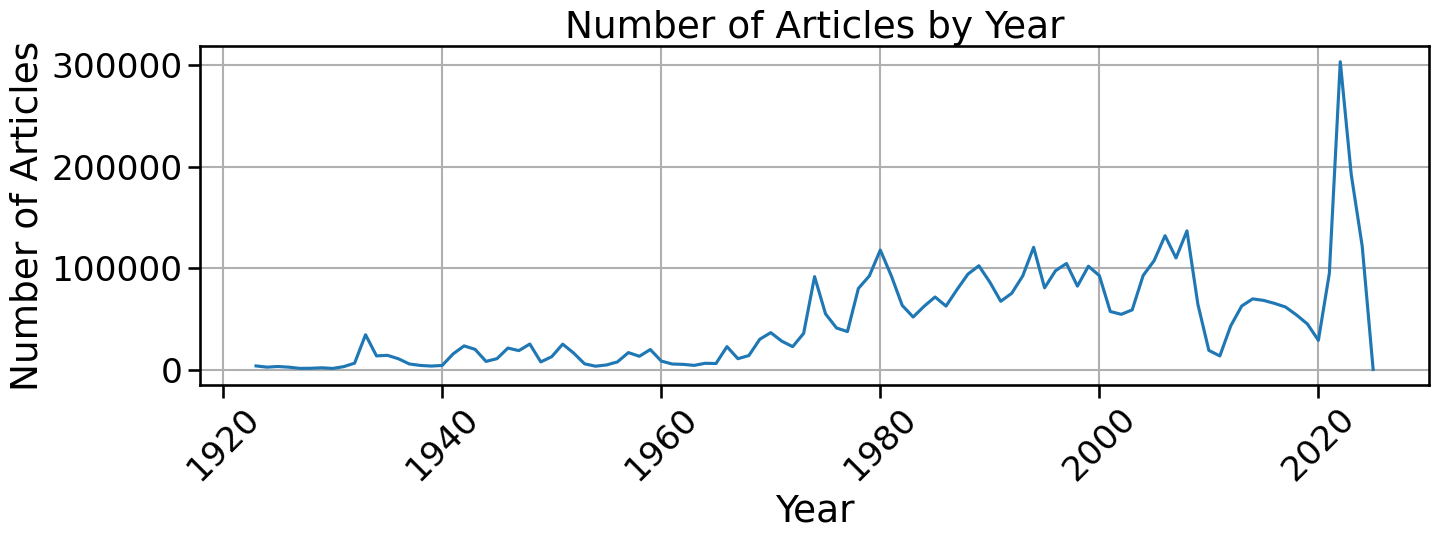

NameError: name 'newspaper_stats' is not defined

<Figure size 1500x600 with 0 Axes>

In [6]:
# Plot temporal distribution of articles
plt.figure(figsize=(15, 6))
yearly_counts = df.groupby('year').size()
sns.lineplot(data=yearly_counts)
plt.title('Number of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot distribution of newspaper coverage periods
plt.figure(figsize=(15, 6))
coverage_lengths = newspaper_stats['end_year'] - newspaper_stats['start_year']
sns.histplot(data=coverage_lengths, bins=30)
plt.title('Distribution of Newspaper Coverage Periods')
plt.xlabel('Coverage Length (Years)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

## Process and Clean Proquest Location Data

Process location data from Proquest by:
1. Extending partial state names to their full names 
2. Combining cities that appear with different state abbreviations 
3. Converting state abbreviations to full state names
This helps standardize location information across the dataset


In [13]:
def extend_substrings(input_list):
    """
    Creates a mapping to extend partial state names to their full names.
    For example, maps 'Mass' to 'Massachusetts' if 'Massachusetts' exists in region_mapping.
    
    Args:
        input_list: List of state names/abbreviations to process
        
    Returns:
        Dictionary mapping partial names to full names
    """
    # Create a dictionary to store the transformation map
    transformation_map = {}

    # Filter out None values and sort the remaining input list by length in descending order
    filtered_list = [word for word in input_list if word is not None]
    sorted_list = sorted(filtered_list, key=len, reverse=True)

    for word in sorted_list:
        # Check if the word is a substring of any other longer word in the list
        for longer_word in utils.region_mapping.keys():
            if longer_word.startswith(word) and word != longer_word:
                transformation_map[word] = longer_word
                break
        else:
            # If the word is not a substring of any other word, map it to itself
            transformation_map[word] = word

    # Add None mapping to None
    transformation_map[None] = None

    return transformation_map

def combine_cities(group):
    """
    Combines city entries that appear with different state abbreviations.
    For cities with multiple state entries, fills missing states with the most common one.
    
    Args:
        group: DataFrame group containing rows for a single city
        
    Returns:
        Processed DataFrame group with standardized state names
    """
    unique_states = group.state.unique()
    expand_states = extend_substrings(unique_states)
    
    group.state = group.state.map(expand_states)
    try:
        # Fill missing states with most common state for this city
        group.state = group.state.fillna(group.state.mode()[0])
        return group
    except:
        return group

def abbrev_to_full(state):
    """
    Converts state abbreviations to full state names using a predefined mapping.
    
    Args:
        state: State name or abbreviation to convert
        
    Returns:
        Full state name if abbreviation exists in mapping, otherwise returns original
    """
    if state is not None:
        no_space = state.replace(" ", "")
        if len(no_space) < 3:  # Likely an abbreviation if less than 3 chars
            state = no_space
    if state in utils.state_abbreviation_to_name:
        return utils.state_abbreviation_to_name[state]
    return state

In [26]:
# Create a copy of the dataframe for cleaning
df_clean = df.copy()

# Clean location strings by removing periods and converting to lowercase
df_clean['loc'] = df_clean['loc'].str.replace(".", "")
df_clean['loc'] = df_clean['loc'].str.lower()

# Split location into city and state components
df_clean[['city', 'state']] = df_clean['loc'].str.split(',', n=1, expand=True)

# Clean up state names and convert abbreviations to full names
df_clean.state = df_clean.state.str.strip()
df_clean.state = df_clean.state.apply(abbrev_to_full)

# Clean up city names
df_clean.city = df_clean.city.str.strip()

# Standardize cities that appear with different state abbreviations
df_clean = df_clean.groupby(['city']).apply(combine_cities)

# Fill in missing states using predefined mapping where possible
df_clean.state = df_clean.apply(lambda x: utils.missing_cities[x.city] if x.state is None and x.city in utils.missing_cities else x.state, axis=1)

# Filter out non-US locations and missing states
df_clean = df_clean[~df_clean.state.isin(['mexico'])]
df_clean = df_clean[df_clean.state.notna()]
df_clean = df_clean.reset_index(drop=True)

# Map states to their corresponding regions
df_clean['region'] = df_clean.state.map(utils.region_mapping)

df = df_clean

# Save processed data to compressed JSON file
df_clean.to_json('/data/mourad/narratives/proquest/processed_data_1923-2025.jsonl.gz', orient='records', lines=True, compression='gzip')

/tmp/ipykernel_2135010/809467823.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby(['city']).apply(combine_cities)


## Sample for human annotation

Based on total unique annotations, 1/3 used for triple annotation (agreement) and remaining divided into 3 subsets for single annotation

In [15]:
def sample_for_labeling(df, year_start, year_end, n=1499, random_state=0):
    """
    Sample articles from a date range for human annotation, distributing them among annotators.
    
    Args:
        df: Input DataFrame containing articles
        year_start: Start year for sampling period
        year_end: End year for sampling period 
        n: Total number of articles to sample (default 1499)
        random_state: Random seed for reproducibility (default 0)
    Returns:
        period_df: DataFrame filtered to the specified date range
        sampled: DataFrame containing sampled articles with annotator assignments
    """    
    # Filter DataFrame to specified date range and add ID column
    period_df = df[(df.year >= year_start) & (df.year <= year_end)]
    period_df['id'] = period_df.index
    
    # Sample n articles randomly
    sampled = df.sample(n=n, random_state=random_state)
    
    # First 500 articles go to subset 1 (will be triple-annotated)
    subset_1 = sampled.iloc[:500]

    # Split remaining articles into 3 equal subsets for single annotation
    remaining_rows = sampled.iloc[500:]
    num_remaining_rows = len(remaining_rows)
    subset_size = num_remaining_rows // 3

    subset_2 = remaining_rows.iloc[:subset_size]
    subset_3 = remaining_rows.iloc[subset_size:2*subset_size]
    subset_4 = remaining_rows.iloc[2*subset_size:]
    
    # Assign annotators to subsets
    # subset_1 gets three annotators (marked with *), others get one each
    all = []
    for subset, annotator_name in [(subset_1, 'mh*'), (subset_1, 'az*'), (subset_1, 'qz*'), 
                                  (subset_2, 'mh'), (subset_3, 'az'), (subset_4, 'qz')]:
        subset = subset.copy()
        subset['annotator'] = annotator_name
        all.append(subset)
    
    # Combine all annotated subsets    
    sampled = pd.concat(all, axis=0)
    
    return period_df, sampled

In [16]:
year_start = 1960
year_end = 1980
n = 1499 # 1/3 used for triple annotation (agreement) and remaining divided into 3 subsets for single annotation
# Set random seed for reproducibility
random_state = 0

period_df, sampled = sample_for_labeling(df, year_start, year_end, n, random_state)

period_df.to_json(f'/data/mourad/narratives/proquest/processed_data_{year_start}-{year_end}.jsonl.gz', orient='records', lines=True, compression='gzip')
# sampled.to_csv(f"../../data/for_labeling/proquest_{year_start}-{year_end}_n{n}_rand{random_state}_v1_061124.csv", index=False)

/tmp/ipykernel_2135010/1002491571.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['id'] = period_df.index


## Miscellaneous Statistical Visualizations / Analyses

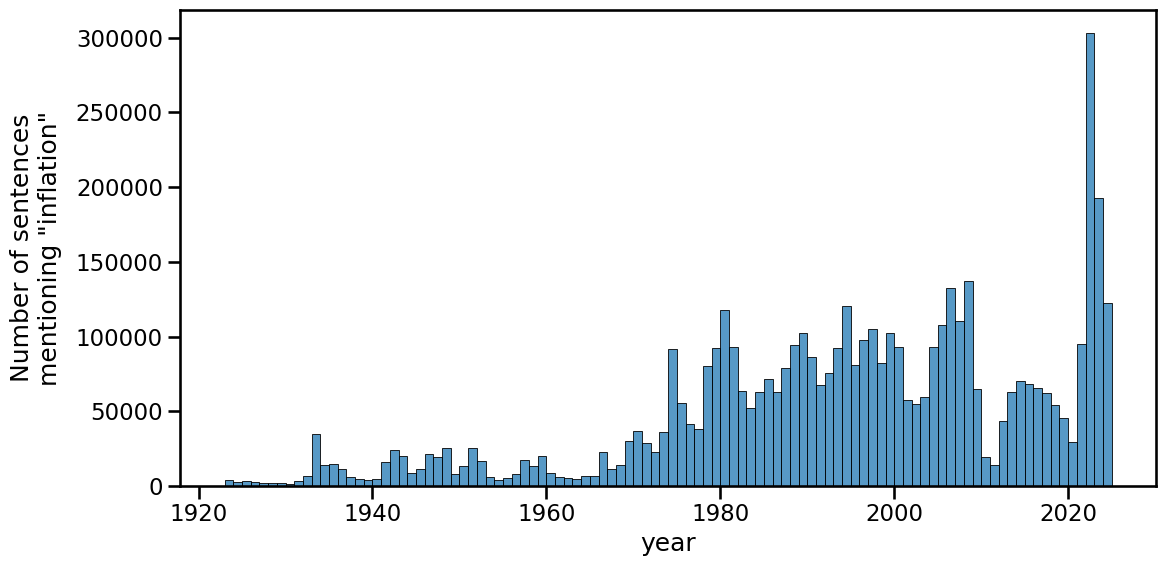

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='year', binwidth=1)
plt.ylabel('Number of sentences\nmentioning "inflation"', labelpad=10)
plt.tight_layout()
plt.show()

<Axes: xlabel='scope', ylabel='Number of sentences\nmentioning "inflation"'>

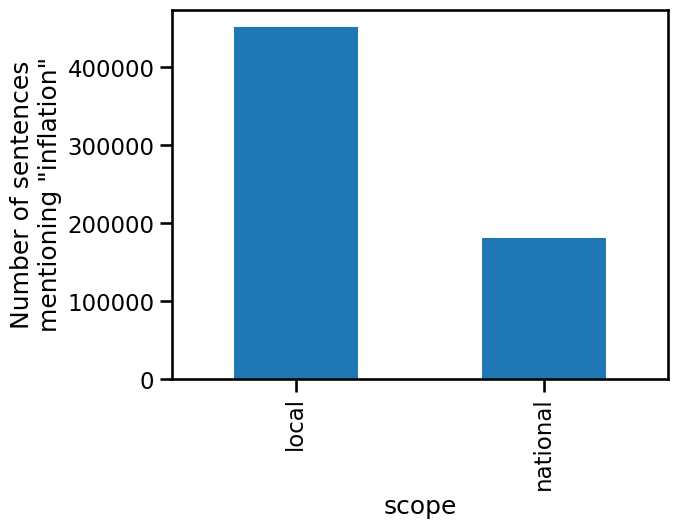

In [24]:
df[(df.year > 1960) & (df.year < 1980)]['scope'].value_counts(normalize=False).plot(kind='bar', ylabel='Number of sentences\nmentioning "inflation"')

<Axes: xlabel='region', ylabel='Number of sentences mentioning "inflation"'>

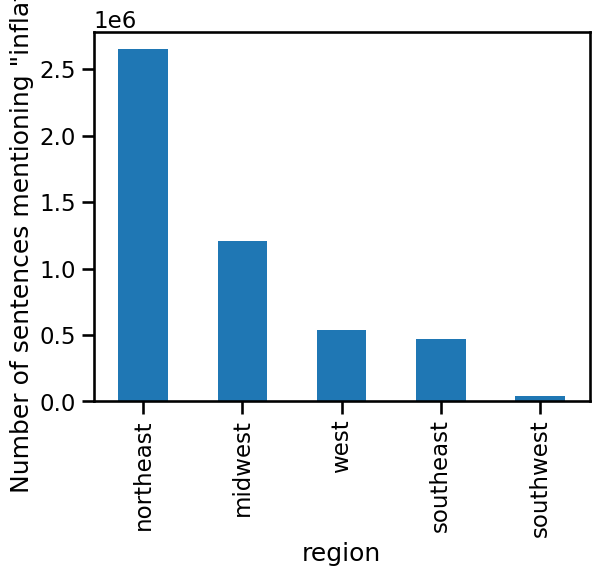

In [27]:
df['region'].value_counts(normalize=False).plot(kind='bar', ylabel='Number of sentences mentioning "inflation"')